In [106]:
import numpy as np
import torch
import torch.utils.data as Data
import torch.nn as nn
import matplotlib.pyplot as plt
from IPython import display

In [107]:
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
features = torch.randn(num_examples, num_inputs,
                       dtype=torch.float32)
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()),
                       dtype=torch.float32) # 加入噪声

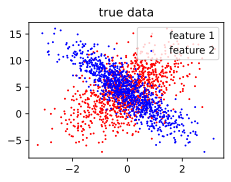

In [108]:
def use_svg_display():
    # 用矢量图显示
    display.set_matplotlib_formats('svg')

def set_figsize(figsize=(10, 6)):
    use_svg_display()
    # 设置图的尺寸
    plt.rcParams['figure.figsize'] = figsize

# # 在../d2lzh_pytorch里面添加上面两个函数后就可以这样导入
# import sys
# sys.path.append("..")
# from d2lzh_pytorch import * 

plt.scatter(features[:, 0].numpy(), labels.numpy(), s=1, c='r', label="feature 1");
plt.scatter(features[:, 1].numpy(), labels.numpy(), s=1, c='b', label="feature 2");
plt.title("true data")
plt.legend(loc="upper right")


In [109]:
batch_size = 10
dataset = Data.TensorDataset(features, labels) # 合并特征和标签得到数据集
data_iter = Data.DataLoader(dataset, batch_size, shuffle=True)

In [110]:
for X, y in data_iter:
    print(X.shape, y.shape)
    print(X)
    print(y)
    break

torch.Size([10, 2]) torch.Size([10])
tensor([[ 1.3867, -0.4825],
        [-0.0741,  0.6790],
        [-1.9385, -0.1267],
        [-0.9960,  0.5573],
        [-0.9395,  1.3057],
        [-0.2016,  0.0106],
        [-1.4001, -0.4039],
        [-0.4226, -0.6033],
        [-1.7017,  0.2491],
        [-0.3726, -0.8307]])
tensor([ 8.6275,  1.7291,  0.7356,  0.3127, -2.1151,  3.7805,  2.7544,  5.3980,
        -0.0391,  6.2660])


In [111]:
# 定义自己的类
class LinearNet(nn.Module):
    def __init__(self, n_features) -> None:
        super(LinearNet, self).__init__()
        self.linear = nn.Linear(n_features, 1)
    
    def forward(self, x):
        return self.linear(x)

mynet = LinearNet(num_inputs)
# nn.Sequential()是一个有序的容器，传入每层网络会被按顺序添加到计算图中
# mynet = nn.Sequential(
#     nn.Linear(num_inputs, 1)
# )
print(mynet)

LinearNet(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)


In [112]:
# 通过nn.parameters()查看模型所有可学习参数
for param in mynet.parameters():
    print(param) # w, b

Parameter containing:
tensor([[0.4929, 0.5778]], requires_grad=True)
Parameter containing:
tensor([0.6395], requires_grad=True)


In [113]:
# 初始化模型参数, 对mynet模型的linear层进行初始化
nn.init.normal_(mynet.linear.weight, mean=0, std=0.01)
nn.init.constant_(mynet.linear.bias, val=0)

Parameter containing:
tensor([0.], requires_grad=True)

In [114]:
# 定义损失函数
loss_fn = nn.MSELoss()

# 定义优化算法
optimizer = torch.optim.SGD(mynet.parameters(), lr=0.03)

# 为子网络设置不同的学习率
# optimizer =optim.SGD([
#                 # 如果对某个参数不指定学习率，就使用最外层的默认学习率
#                 {'params': net.subnet1.parameters()}, # lr=0.03
#                 {'params': net.subnet2.parameters(), 'lr': 0.01}
#             ], lr=0.03)

print(optimizer)

# 调整学习率
for param_group in optimizer.param_groups:
    param_group['lr'] *= 0.1 # 学习率为之前的0.1倍


SGD (
Parameter Group 0
    dampening: 0
    lr: 0.03
    momentum: 0
    nesterov: False
    weight_decay: 0
)


In [115]:
# 训练模型
def train(data_iter, model, loss_fn, optimizer):
    for X, y in data_iter:
        output = model(X)
        loss = loss_fn(output, y.view(-1, 1))

        optimizer.zero_grad() # 梯度清零，等价于mynet.zero_grad()
        loss.backward()
        optimizer.step() # 进行一次迭代
    return loss

epochs = 5
for epoch in range(epochs):
    loss = train(data_iter, mynet, loss_fn, optimizer)
    print('epoch %d, loss: %f' % (epoch, loss.item()))


epoch 0, loss: 7.032332
epoch 1, loss: 3.085290
epoch 2, loss: 1.213749
epoch 3, loss: 0.237231
epoch 4, loss: 0.031305


In [116]:
# 从net获得需要的层，并访问其权重（weight）和偏差（bias）
dense = mynet.linear
print(true_w, dense.weight)
print(true_b, dense.bias)


[2, -3.4] Parameter containing:
tensor([[ 1.9191, -3.2715]], requires_grad=True)
4.2 Parameter containing:
tensor([4.0137], requires_grad=True)
